# 基于词向量的英汉翻译——“火炬上的深度学习"下第一次作业

在这个作业中，你需要半独立地完成一个英文到中文的单词翻译器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [1]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包，主要为了词向量的二维可视化
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载正则表达式处理的包
import re

#在Notebook界面能够直接显示图形
%matplotlib inline

## 第一步：加载词向量

首先，让我们加载别人已经在大型语料库上训练好的词向量

In [2]:
# 加载中文词向量，下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg
# 该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量
word_vectors = KeyedVectors.load_word2vec_format('/Users/wizardholy/Documents/GitHub/eyespage-nlp/nlpdemo/datas/vectors.bin', binary=True, unicode_errors='ignore')
len(word_vectors.vocab)

1366130

In [12]:
# 加载中文的词向量，下载地址为：http://nlp.stanford.edu/data/glove.6B.zip，解压后将glove.6B.100d.txt文件拷贝到与本notebook
# 文件一致的文件夹洗面。
f = open('/Users/wizardholy/Documents/ml/pytorch-深度学习/glove.6B/glove.6B.100d.txt', 'r')
j = 1

# 将英文的词向量都存入如下的字典中
word_vectors_en = {}
with open('/Users/wizardholy/Documents/ml/pytorch-深度学习/glove.6B/glove.6B.100d.txt') as f:
    for line in f:
        numbers = line.split()
        word = numbers[0]
        vectors = np.array([float(i) for i in numbers[1 : ]])
        word_vectors_en[word] = vectors
        j = j + 1
print(str(len(word_vectors_en)))

400000


## 第二步：可视化同一组意思词在两种不同语言的词向量中的相互位置关系

In [18]:
# 中文的一二三四五列表
cn_list = {'一', '二', '三', '四', '五', '六', '七', '八', '九', '零'}
# 阿拉伯数字的12345列表
en_list = {'1', '2', '3', '4', '5', '6', '7', '8', '9', '0'}
# 英文数字的列表
en_list = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero'}

# 对应词向量都存入到列表中
cn_vectors = []  #中文的词向量列表
en_vectors = []  #英文的词向量列表
for w in cn_list:
    cn_vectors.append(word_vectors[w.decode('utf-8')])
for w in en_list:
    en_vectors.append(word_vectors_en[w])

# 将这些词向量统一转化为矩阵
cn_vectors = np.array(cn_vectors)
en_vectors = np.array(en_vectors)

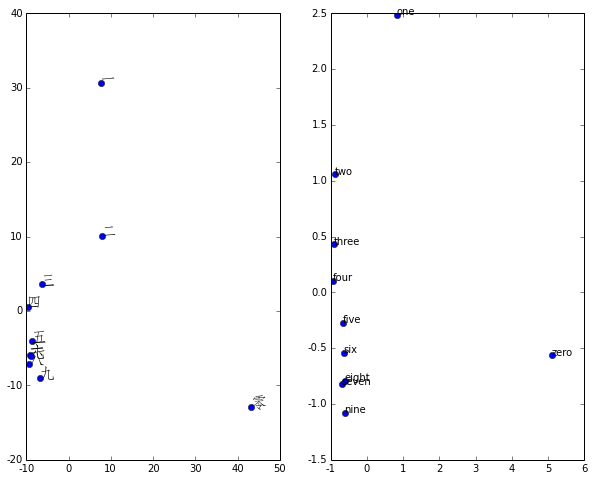

In [29]:
# 降维实现可视化
X_reduced = PCA(n_components=2).fit_transform(cn_vectors)
Y_reduced = PCA(n_components = 2).fit_transform(en_vectors)

# 绘制所有单词向量的二维空间投影
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
ax1.plot(X_reduced[:, 0], X_reduced[:, 1], 'o')
ax2.plot(Y_reduced[:, 0], Y_reduced[:, 1], 'o')
zhfont1 = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/华文仿宋.ttf', size=16)
for i, w in enumerate(cn_list):
    ax1.text(X_reduced[i, 0], X_reduced[i, 1], w.decode("utf-8"), fontproperties = zhfont1, alpha = 1)
for i, w in enumerate(en_list):
    ax2.text(Y_reduced[i, 0], Y_reduced[i, 1], w, alpha = 1)

### 结论：可以看出，中文的一、二、等数字彼此之间的关系与英文的数字彼此之间的关系很类似

## 第三步：训练一个神经网络，输入一个英文单词的词向量，输出一个中文的词向量，并翻译为中文

首先，读入一个已经建立好的词典（dictionary.txt）。本词典是老师调用百度翻译的API，自动将一篇英文小说中的词汇逐个翻译为中文而得来的

我们一个个地载入词典，并查找对应的中文词向量，如果找得到，则放入original_words中，做为正式的训练集

In [70]:
original_words = []
with open('dictionary.txt', 'r') as f:
    dataset = []
    for line in f:
        itm = line.split('\t')
        eng = itm[0].strip()
        chn = itm[1].strip()
        chn = chn.decode('utf-8')
        if eng in word_vectors_en and chn in word_vectors:
            data = word_vectors_en[eng]
            target = word_vectors[chn]
            #将中英文词对做成数据集
            dataset.append([data, target])
            original_words.append([eng, chn])
        
# words = word_vectors.most_similar(positive=[u'美元', u'英镑', u'日元'], topn = 20)
#words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], negative = ['原油价格', '7800万'], topn = 100)
# for item in words:
#     print item[0], item[1]
print(len(dataset)) # 共有4962个单词做为总的数据集合


4962


In [78]:
# 建立训练集、测试集和校验集
# 训练集用来训练神经网络，更改网络的参数；校验集用来判断网络模型是否过拟合：练集的时候，即为过拟合
# 测试集用来检验模型的好坏
indx = np.random.permutation(range(len(dataset)))
dataset = [dataset[i] for i in indx]
original_words = [original_words[i] for i in indx]
train_size = 500
train_data = dataset[train_size:]
valid_data = dataset[train_size // 2 : train_size]
test_data = dataset[: train_size // 2]
test_words = original_words[: train_size // 2]

In [99]:
# 开始训练一个多层神经网络，将一个100维度的英文向量映射为200维度的中文词向量，隐含层节点为30
input_size = 100
output_size = 200
hidden_size = 40

# 新建一个神经网络，包含一个隐含层
model = nn.Sequential(nn.Linear(input_size, hidden_size),
                    nn.Tanh(),
                    nn.Linear(hidden_size, output_size)
                    )

# 构造损失函数
criterion = torch.nn.MSELoss()

# 构造优化器
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# 总的循环周期
num_epoch = 120


#开始训练500次，每次对所有的数据都做循环
results = []
for epoch in range(num_epoch):
    train_loss = []
    for data in train_data:
        # 读入数据
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        # 模型预测
        output = model(x)
        
        # 反向传播算法训练
        optimizer.zero_grad()
        loss = criterion(output, y)
        train_loss.append(loss.data.numpy()[0])
        loss.backward()
        optimizer.step()
    # 在校验集上测试一下效果
    valid_loss = []
    for data in valid_data:
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        output = model(x)
        loss = criterion(output, y)
        valid_loss.append(loss.data.numpy()[0])
    results.append([np.mean(train_loss), np.mean(valid_loss)])
    print('{}轮，训练Loss: {:.2f}, 校验Loss: {:.2f}'.format(epoch, np.mean(train_loss), np.mean(valid_loss)))

0轮，训练Loss: 8.72, 校验Loss: 7.99
1轮，训练Loss: 8.25, 校验Loss: 7.68
2轮，训练Loss: 7.99, 校验Loss: 7.52
3轮，训练Loss: 7.83, 校验Loss: 7.41
4轮，训练Loss: 7.72, 校验Loss: 7.33
5轮，训练Loss: 7.63, 校验Loss: 7.27
6轮，训练Loss: 7.56, 校验Loss: 7.22
7轮，训练Loss: 7.49, 校验Loss: 7.18
8轮，训练Loss: 7.44, 校验Loss: 7.14
9轮，训练Loss: 7.40, 校验Loss: 7.11
10轮，训练Loss: 7.36, 校验Loss: 7.08
11轮，训练Loss: 7.32, 校验Loss: 7.06
12轮，训练Loss: 7.29, 校验Loss: 7.04
13轮，训练Loss: 7.25, 校验Loss: 7.02
14轮，训练Loss: 7.23, 校验Loss: 7.00
15轮，训练Loss: 7.20, 校验Loss: 6.99
16轮，训练Loss: 7.18, 校验Loss: 6.97
17轮，训练Loss: 7.16, 校验Loss: 6.96
18轮，训练Loss: 7.14, 校验Loss: 6.95
19轮，训练Loss: 7.12, 校验Loss: 6.94
20轮，训练Loss: 7.11, 校验Loss: 6.93
21轮，训练Loss: 7.09, 校验Loss: 6.93
22轮，训练Loss: 7.08, 校验Loss: 6.92
23轮，训练Loss: 7.07, 校验Loss: 6.91
24轮，训练Loss: 7.06, 校验Loss: 6.91
25轮，训练Loss: 7.05, 校验Loss: 6.90
26轮，训练Loss: 7.04, 校验Loss: 6.90
27轮，训练Loss: 7.03, 校验Loss: 6.90
28轮，训练Loss: 7.02, 校验Loss: 6.89
29轮，训练Loss: 7.01, 校验Loss: 6.89
30轮，训练Loss: 7.00, 校验Loss: 6.88
31轮，训练Loss: 7.00, 校验Loss: 6.88
32轮，训练Loss: 6.99, 

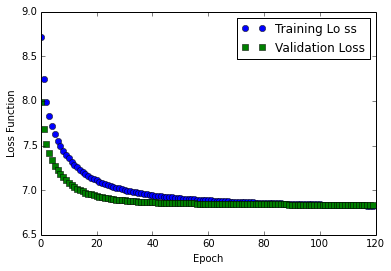

In [100]:
# 绘制图形
a = [i[0] for i in results]
b = [i[1] for i in results]
plt.plot(a, 'o', label = 'Training Lo ss')
plt.plot(b, 's', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()

In [101]:
# 在测试集上验证准确度
# 检验标准有两个：一个是直接用预测的词和标准答案做全词匹配；另一个是做单字的匹配
exact_same = 0  #全词匹配数量
one_same = 0 #单字匹配数量
results = []
for i, data in enumerate(test_data):
    x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
    # 给出模型的输出
    output = model(x)
    output = output.squeeze().data.numpy()
    # 从中文词向量中找到与输出向量最相似的向量
    most_similar = word_vectors.wv.similar_by_vector(output, 1)
    # 将标准答案中的词与最相似的向量所对应的词打印出来
    results.append([original_words[i][1], most_similar[0][0]])
    
    # 全词匹配
    if original_words[i][1] == most_similar[0][0]:
        exact_same += 1
    # 某一个字匹配
    if list(set(list(original_words[i][1])) & set(list(most_similar[0][0]))) != []:
        one_same += 1
    
print("精确匹配率：{:.2f}".format(1.0 * exact_same / len(test_data)))
print('一字匹配率：{:.2f}'.format(1.0 * one_same / len(test_data)))
for item in results:
    print item[0], item[1]

精确匹配率：0.13
一字匹配率：0.22
茶 小子
荣耀 不朽
授权 申请
保护 保护
加 每人
恶意 激怒
解决 问题
大步 转圈
全面 吓到
重复 生硬
急性 不安
这里 这里
屏幕 屏幕
借口 因为
哈达 散步
步进 后退
重量 强度
约 怀疑
轻度 干燥
四 吟唱
拍摄 射杀
放松 放松
干扰 恐惧
马力 载荷
英济 飓风
无味 恶心
逃 逃走
指出 斜着
缝 木板
妈妈 我
相似 怪异
顺口 说
由 组成
维尔 山中
奥拓 功率放大器
植被 植被
字符串 弹
环 骷髅头
窃笑 诧异
否则 因为
认为 或者说
胶 肉
压 递给
女儿 她
模糊 模棱两可
蔬菜 蔬菜
禁止 强迫
谁 他们
冲浪板 悬吊
架 凹槽
同情 感动
砂 沙土
得到 真的
斗争 意志
短缺 导致
更长 即使
是 哎
不休 恐惧
镜 物体
分开 拉扯
未来 利益
债务 资金
存款 返还
翻领 胸前
短 短
科学家 科学家
看到 似乎
活动 组织
含 内含
角 对角线
凝视 看见
形 形状
猎枪 锯
补救 导致
光滑 色带
决定 变量
埃及 埃及
扫 冲出
厌恶 沮丧
出租车 司机
破坏 毁坏
邮递员 护士
生气 愤慨
别人 他们
诗歌 艺术
无论 所以
咨询 管理
冰箱 盒
压力 劳累
抱怨 说
饥饿 痛苦
叶片 锯
冷淡 示意
抽 加压
增加 增加
解 方法
重 破坏
阿比林 克劳德·
单独 哪怕
20 10
箭 长矛
平静 平静
原 构造
佛洛伊德 叙述
多 因为
微风 海浪
等待 告知
易腐 贮存
逗乐 诧异
花园 庄园
小 大小不一
上船 船上
潮湿 潮湿
十月 11
走私 截获
检查 研究
腿 脚
代码 编码
证明 实际上
沉 掉
补偿 损失
解决 解决问题
帮助 帮助
融 破裂
取代 替换
泄漏 泄漏
喜欢 喜欢
刷 倒
采取 观察
买 购买
拱形 凹
最近 附近
抓住 卡住
不良 物质
管理员 喊叫
在 仿佛
25 10
或 或者
痛苦 痛苦
侮辱 侮辱
皇后 教堂
鼓励 兴奋
鹿 虫子
衬衫 衣服
大师 艺术
偷 取走
解锁 按钮
业务 企业
孩子 妈妈
哼声 生气
愤怒 咆哮
吱吱 裂开
车把 钳
现实 合理
声音 声音
愿景 故事
长筒靴 衣领
双 底面
片 木屑
修剪 抽打
火炬 腾空而起
上校 上校
托盘 托盘
板 牙签
枪 手枪
他们 的
生存 的
同意 拒绝
